In [7]:
!gdown https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights  ## yolov4 weights

Downloading...
From: https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights
To: /content/yolov4.weights
100% 258M/258M [00:14<00:00, 17.3MB/s]


In [ ]:
!gdown https://raw.githubusercontent.com/Tianxiaomo/pytorch-YOLOv4/master/cfg/yolov4.cfg ##yolov4 cfg

Downloading...
From: https://raw.githubusercontent.com/Tianxiaomo/pytorch-YOLOv4/master/cfg/yolov4.cfg
To: /content/yolov4.cfg
12.2kB [00:00, 9.79MB/s]     


In [8]:
!gdown https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names ##coco names

Downloading...
From: https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names
To: /content/coco.names
625B [00:00, 2.98MB/s]       


# Original Picture (all classes detected)




In [65]:
import cv2
import time
import numpy as np
from google.colab.patches import cv2_imshow

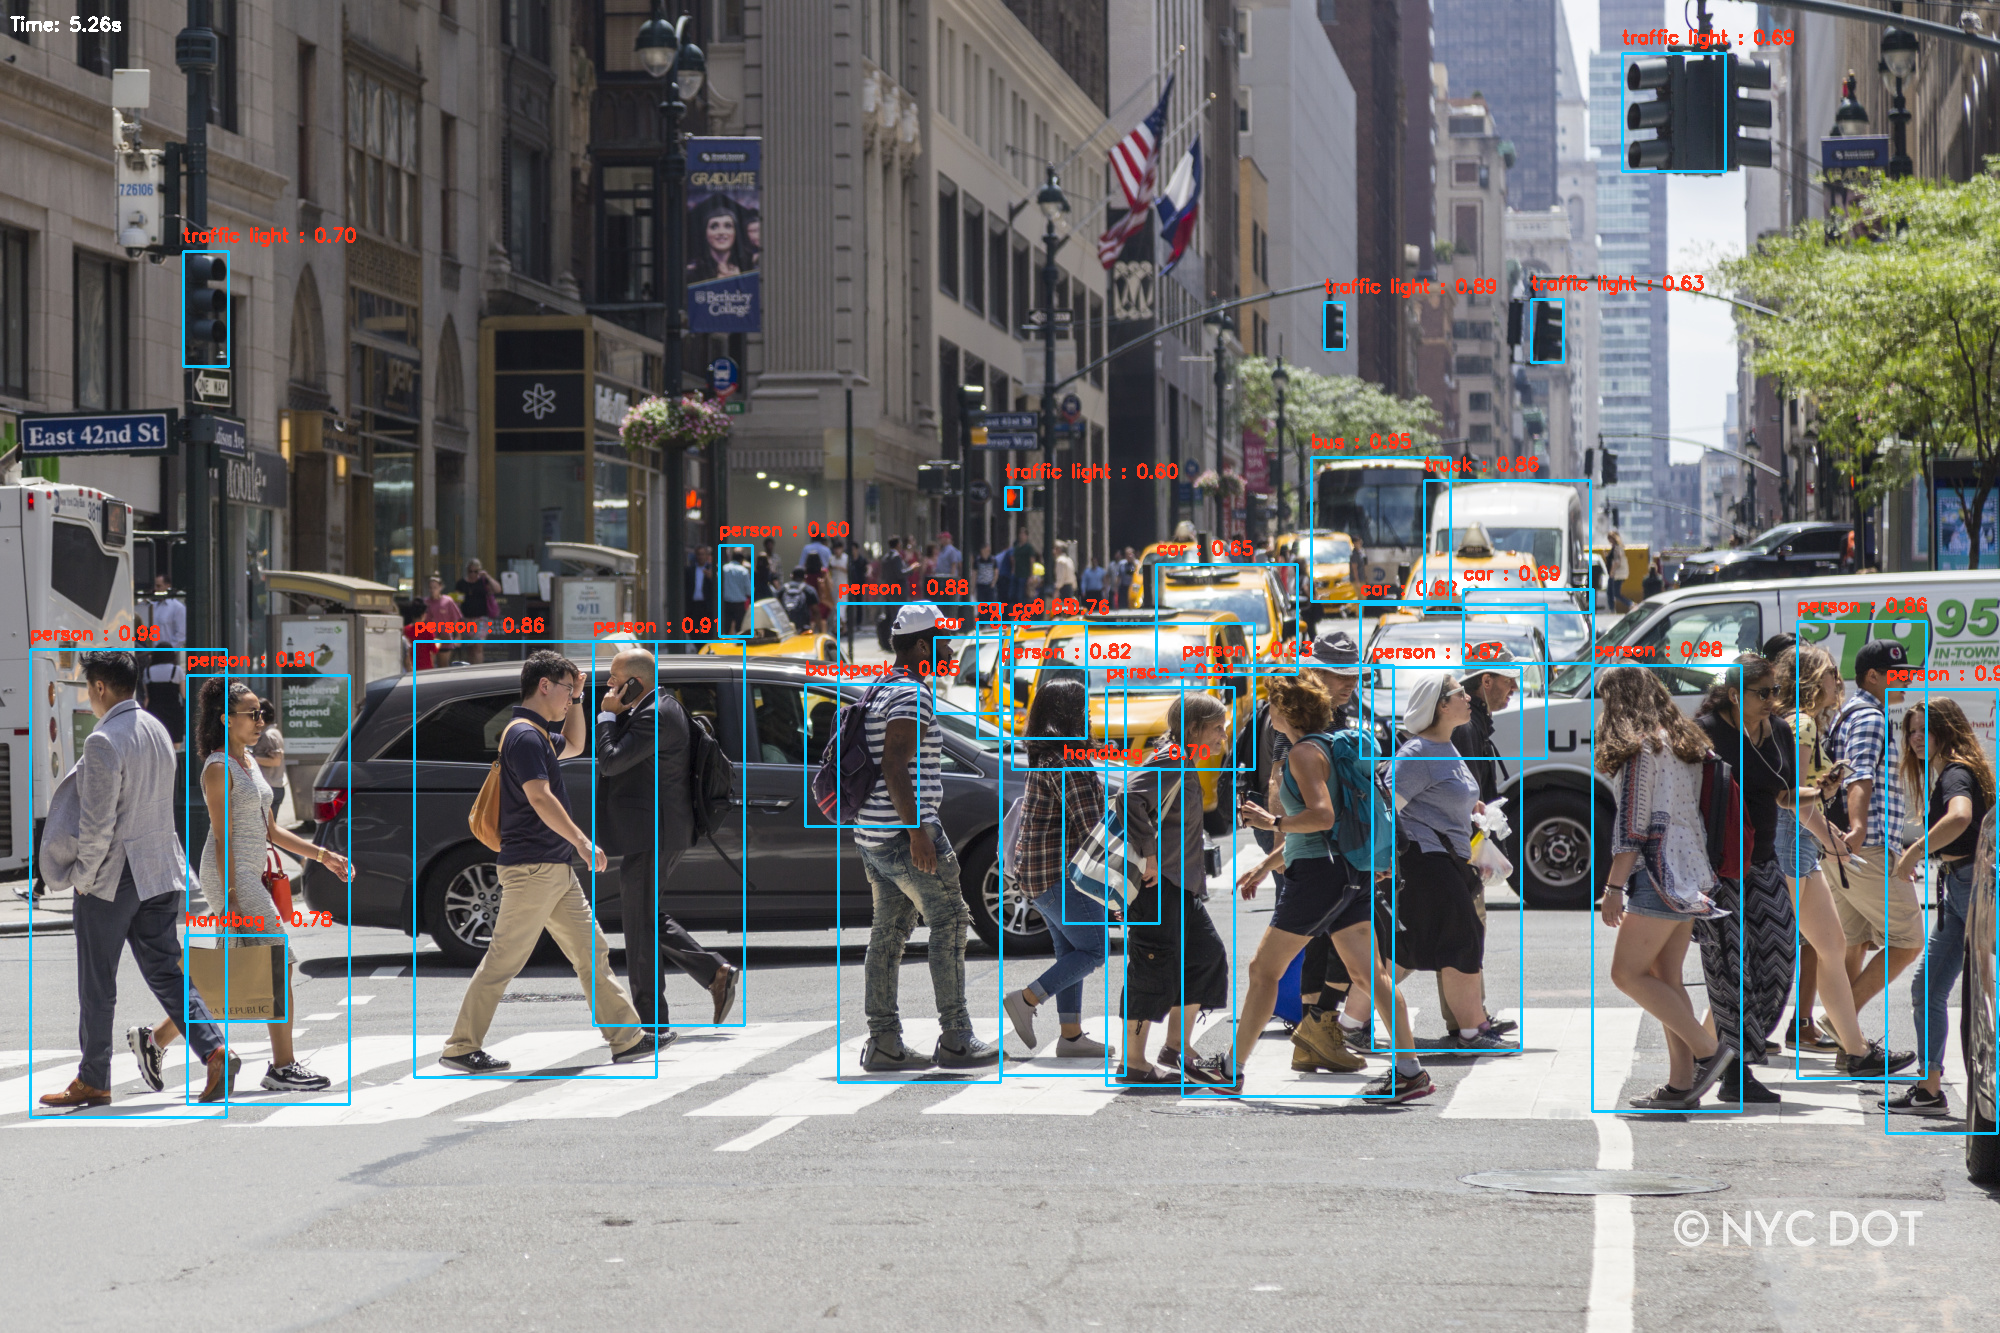

In [67]:
confidence = 0.6
Nms= 0.3
class_names = []

with open("coco.names", "r") as f:
  class_names = [cname.strip() for cname in f.readlines()]

img = cv2.imread("/content/1.jpg")
arc = cv2.dnn.readNet("yolov4.weights","yolov4.cfg")
arc.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
arc.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA_FP16)
model = cv2.dnn_DetectionModel(arc)
model.setInputParams(size=(640,640), scale=1/255, swapRB=True)

start_time = time.time()

classes, scores, boxes = model.detect(img, confidence, Nms)
for (classid, score, box) in zip(classes, scores, boxes):
    label = "%s : %.2f" % (class_names[classid], score)
    cv2.rectangle(img, box, color=(255, 200, 10), thickness=2)
    cv2.putText(img, label, (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (25, 55, 255), 2)

end_time = time.time()
detection_time = end_time - start_time

time_text = "Time: %.2fs" % detection_time
cv2.putText(img, time_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

cv2_imshow(img)



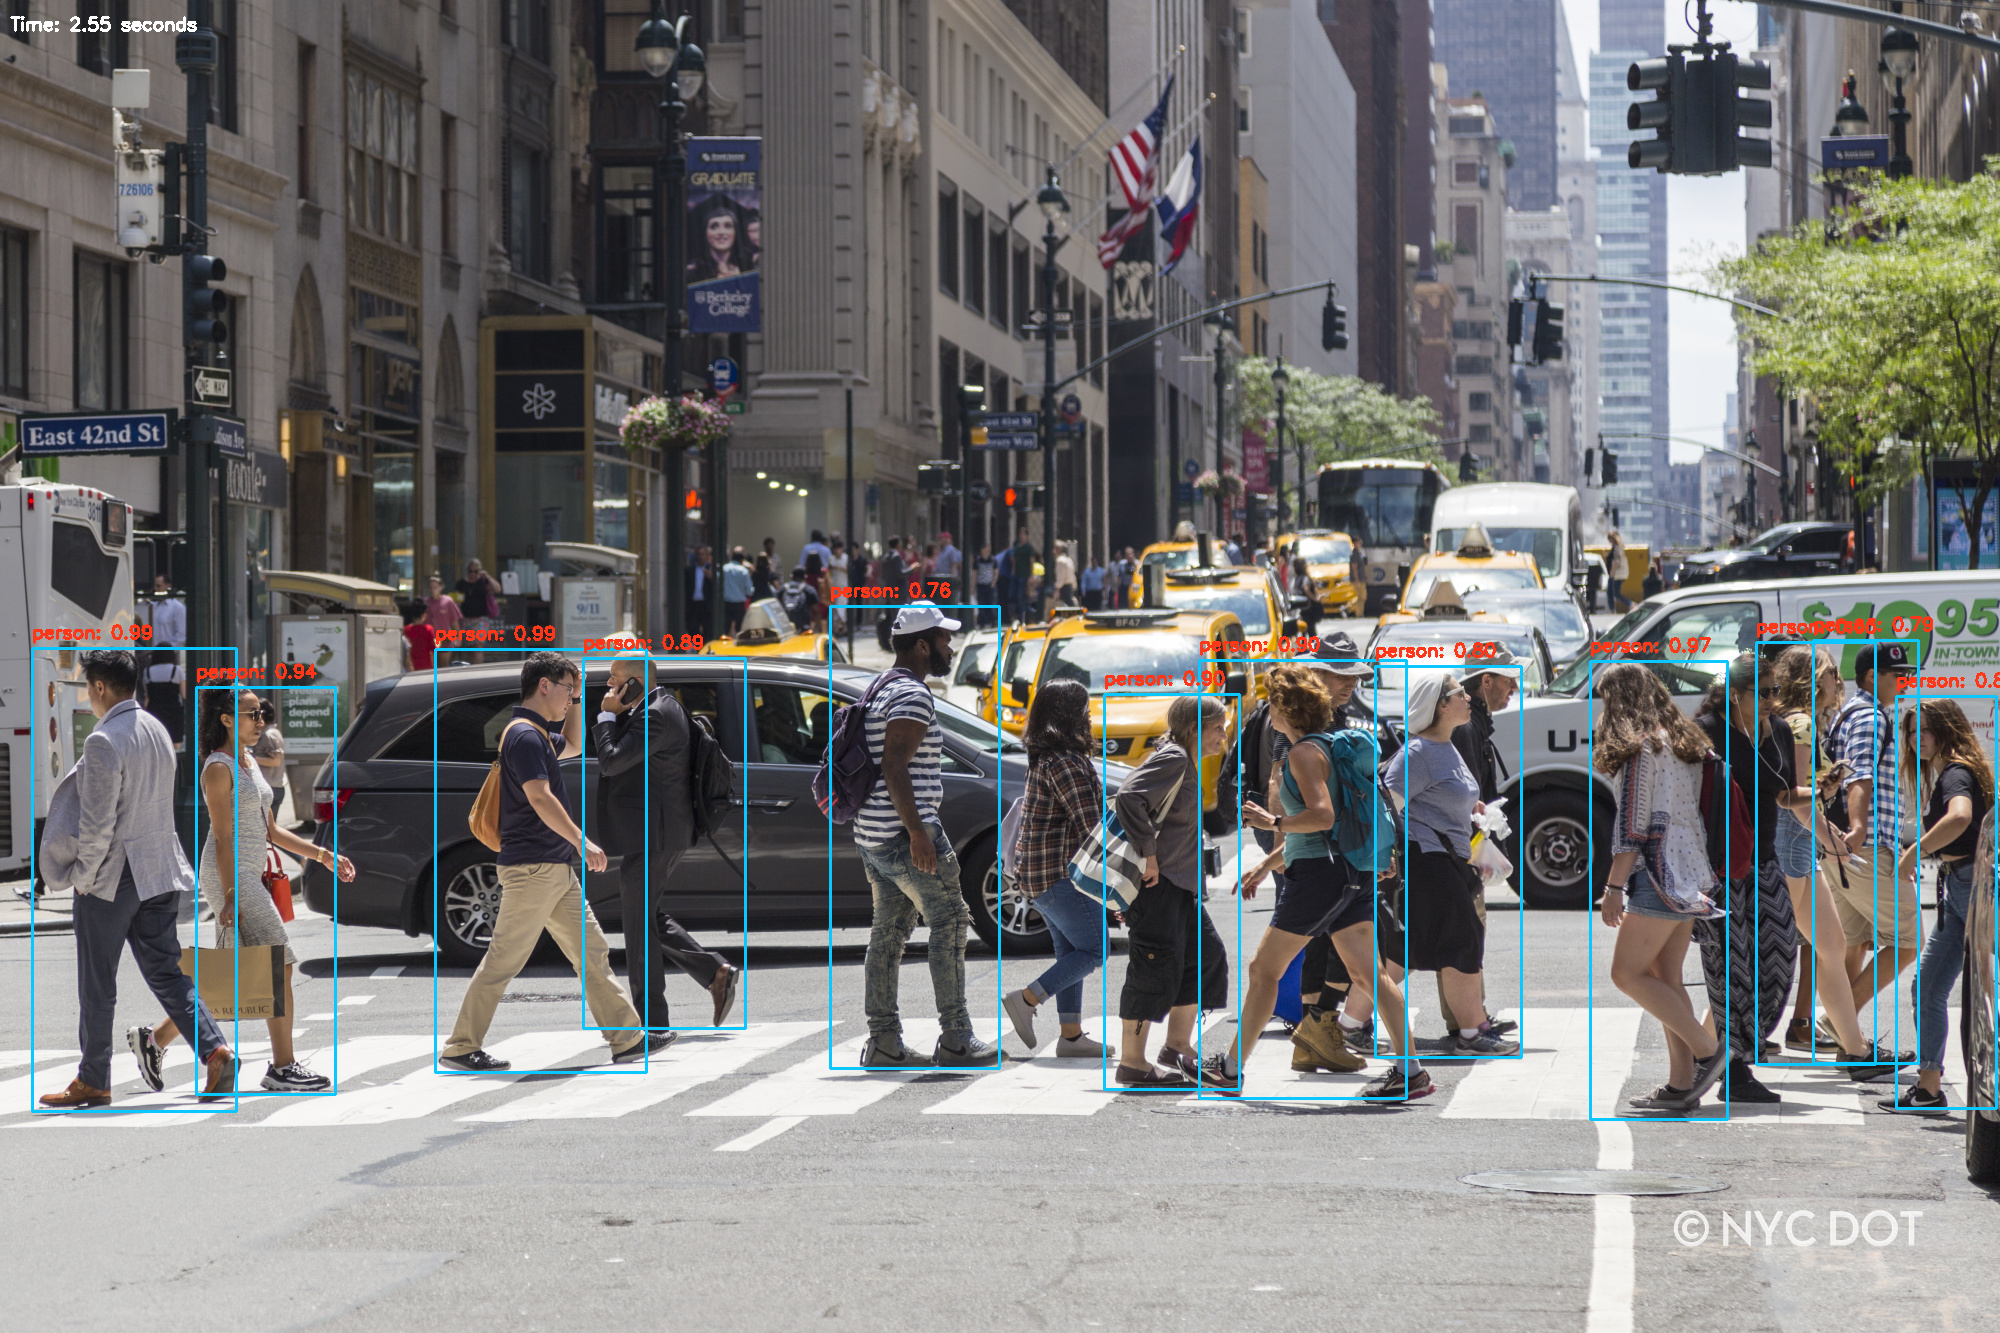

In [69]:
import cv2
import numpy as np
import time
from google.colab.patches import cv2_imshow

YOLO_CONFIG_FILE = '/content/yolov4.cfg'
YOLO_WEIGHTS_FILE = '/content/yolov4.weights'
COCO_LABELS_FILE = '/content/coco.names'
CONFIDENCE_MIN = 0.5

# Load YOLO model
net = cv2.dnn.readNetFromDarknet(YOLO_CONFIG_FILE, YOLO_WEIGHTS_FILE)

with open(COCO_LABELS_FILE, 'r') as f:
    labels = f.read().strip().split('\n')

image_path = '/content/1.jpg'
image = cv2.imread(image_path)
(H, W) = image.shape[:2]

# Prepare blob for YOLO model
blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
net.setInput(blob)

# Get output layer names
output_layer_names = net.getUnconnectedOutLayersNames()

# Perform inference
start_time = time.time()
layer_outputs = net.forward(output_layer_names)

# Process detections
boxes_detected = []
confidences_scores = []
class_ids = []

for output in layer_outputs:
    for detection in output:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]

        if confidence > CONFIDENCE_MIN and labels[class_id] == 'person':
            box = detection[0:4] * np.array([W, H, W, H])
            (center_x, center_y, width, height) = box.astype("int")
            x = int(center_x - (width / 2))
            y = int(center_y - (height / 2))

            boxes_detected.append([x, y, int(width), int(height)])
            confidences_scores.append(float(confidence))
            class_ids.append(class_id)

# Non-maximum suppression
indexes = cv2.dnn.NMSBoxes(boxes_detected, confidences_scores, CONFIDENCE_MIN, 0.4)

# Drawing boxes and labels
for i in indexes:
    (x, y, w, h) = boxes_detected[i]
    label = f"{labels[class_ids[i]]}: {confidences_scores[i]:.2f}"

    cv2.rectangle(image, (x, y), (x + w, y + h), (255, 200, 10), 2)
    cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (25, 55, 255), 2)


end_time = time.time()
detection_time = end_time - start_time

# Display the image with detections and time
time_text = f"Time: {detection_time:.2f} seconds"
cv2.putText(image, time_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
cv2_imshow(image)
